In [1]:
import torch
from torch import nn,optim
from mltools import ld,draw,models

In [2]:
train_iter,val_iter,test_iter=ld.mnist('./data',batch_size=1000) # 获取训练集、验证集和测试集
rnn_layer=nn.LSTM(28, hidden_size=512, batch_first=True, bidirectional=True) # 定义循环网络LSTM
model=models.RNNModel(rnn_layer, vocab_size=28, step_size=28, output_size=10, one_hot=False) # 定义训练模型
device=torch.device('cuda')

Epoch 0, Training loss 1.330952525138855, Validation loss 1.299780249595642
Epoch 1, Training loss 0.6680753231048584, Validation loss 0.6839874982833862
Epoch 2, Training loss 0.5292315483093262, Validation loss 0.5353758335113525
Epoch 3, Training loss 0.4452908933162689, Validation loss 0.4749848544597626
Epoch 4, Training loss 0.4164317548274994, Validation loss 0.4362829327583313
Epoch 5, Training loss 0.35932525992393494, Validation loss 0.40923774242401123
Epoch 6, Training loss 0.3980679214000702, Validation loss 0.40553271770477295
Epoch 7, Training loss 0.3830423057079315, Validation loss 0.34967076778411865
Epoch 8, Training loss 0.3742744028568268, Validation loss 0.40091750025749207
Epoch 9, Training loss 0.3518216609954834, Validation loss 0.3625949025154114
Epoch 10, Training loss 0.43298885226249695, Validation loss 0.37424808740615845
Epoch 11, Training loss 0.3707849979400635, Validation loss 0.37410590052604675
Epoch 12, Training loss 0.3068573772907257, Validation l

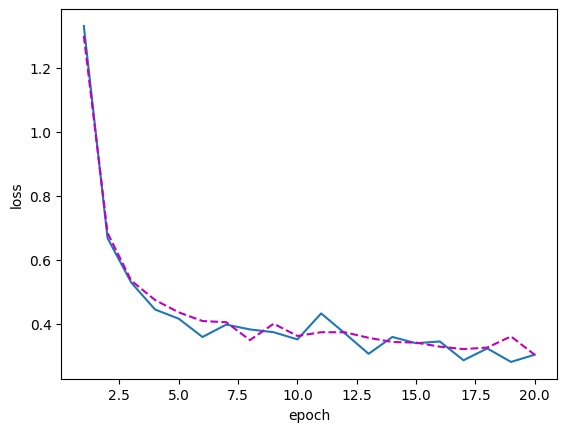

In [3]:
# 训练
def train(model, train_iter, val_iter, *, num_epochs, learning_rate, device):
    model.to(device) # 将网络复制到device上
    loss = nn.CrossEntropyLoss() # 定义损失函数
    optimizer = torch.optim.SGD(model.parameters(), learning_rate) # 定义优化器
    train_losses,val_losses=[],[] # 记录训练集和验证集的损失值
    for epoch in range(num_epochs):
        # 计算训练集
        for x, y in train_iter:
            # 运算
            x, y = x.squeeze(1).to(device), y.to(device)
            y_train, _ = model(x)
            train_loss = loss(y_train, y)
            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
            optimizer.step()
        # 计算验证集
        with torch.no_grad():
            for x, y in val_iter:
                # 运算
                x, y = x.squeeze(1).to(device), y.to(device)
                y_val, _ = model(x)
                val_loss = loss(y_val, y)
        # 添加损失值
        train_losses.append(train_loss.detach().cpu())
        val_losses.append(val_loss.detach().cpu())        
        print(f"Epoch {epoch}, Training loss {train_loss}, Validation loss {val_loss}") # 打印损失值
    draw.plot(y=[train_losses,val_losses],xlabel='epoch',ylabel='loss') # 画出损失图
train(model,train_iter,val_iter,num_epochs=20,learning_rate=1e-1,device=device)

In [4]:
# 测试模型
def test(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    test_num,real_num=0,0 # 定义测试数量和预测真实数量
    # 测试
    for x,y in test_iter:
        x,y=x.squeeze(1).to(device),y.to(device)
        y_test, _ = model(x)
        y_test=y_test.argmax(dim=1)
        pred=y==y_test
        test_num+=len(pred)
        real_num+=pred.sum()
    print(f'Accuracy rate {real_num/test_num}') # 计算测试准确率并输出
test(model,test_iter,device)

Accuracy rate 0.9108999967575073


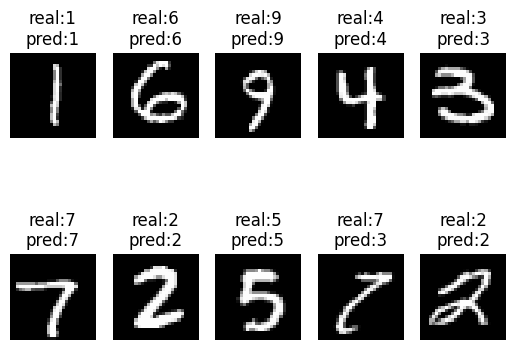

In [6]:
# 预测模型
def predict(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x,y=next(iter(test_iter))
    x,y=x[:10].squeeze(1).to(device),y[:10].to(device)
    # 预测
    y_pred, _ = model(x)
    y_pred = y_pred.argmax(dim=1)
    labels=[f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x.unsqueeze(1),labels,shape=(2,5))
predict(model,test_iter,device)